In [11]:
#IMPORTS
import string
from collections import Counter
import datetime as dt
from numpy import array
import numpy as np
import pickle
from pickle import load, dump
# from keras.applications.inception_v3 import InceptionV3
# from keras.applications import ResNet152V2
from keras.applications import InceptionResNetV2
from keras.models import Model
from keras.preprocessing import image
# from keras.applications.inception_v3 import preprocess_input
# from keras.applications.resnet_v2 import preprocess_input
from keras.applications.inception_resnet_v2 import preprocess_input
from keras import Input
from keras.layers import Dropout, Dense, Embedding, LSTM, GaussianDropout, BatchNormalization
from keras.layers.merge import add
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import keras.backend as K
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#RUN THIS CELL ONLY ONCE
import wandb
wandb.init(project="model7")

wandb: Wandb version 0.9.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


W&B Run: https://app.wandb.ai/vipul43/model7/runs/368ztcwf

In [3]:
#EXTRACTING TEXT DATA AND PREPROCESSING
#STEP: EXTRACTING DATA
filepath = "../../../Downloads/Flickr8k/Flickr8k_text/Flickr8k.token.txt"
file = open(filepath, 'r')
content = file.read()
file.close()
lines = content.split('\n')

#STEP: SAVING DATA IN A DICTIONARY FOR TIME EFFICIENCY PURPOSES
tokens_dic = {}
for line in lines:
    tokens = line.split()
    image_ = tokens[0]
    caption = ' '.join(tokens[1:])
    image_title = image_.split('.')[0]
    if(image_title not in tokens_dic.keys()):
        tokens_dic[image_title] = [caption]
    else:
        tokens_dic[image_title].append(caption)


#STEP: PREPROCESSING
table = str.maketrans('', '', string.punctuation)
for captions in tokens_dic.values():
    for i in range(len(captions)):
        caption = captions[i]
        words = caption.split()
        words = [word.lower() for word in words]
        words = [word.translate(table) for word in words]
        words = [word for word in words if len(word)>1]
        words = [word for word in words if word.isalpha()]
        captions[i] = ' '.join(words)
        

#LOADING TRAINING SET

#STEP: EXTRACTING DATA
filepath = "../../../Downloads/Flickr8k/Flickr8k_text/Flickr_8k.trainImages.txt"
file = open(filepath, "r")
content = file.read()
file.close()
lines = content.split('\n')

#STEP: SAVING DATA IN A LIST
train = []
for line in lines:
    [image_title, stuff] =  line.split('.')
    train.append(image_title)
#NOTE: SIZE OF TRAIN LIST IS 6000

#STEP: SAVING IMAGE-CAPTIONS IN TRAIN DATASET
train_dataset = {}
max_caption_length = 0
for image_title, captions in tokens_dic.items():
    if(image_title in train and (image_title not in train_dataset.keys())):
        train_dataset[image_title] = list()
        for caption in captions:
            refined_caption = "startseq " + caption + " endseq"
            train_dataset[image_title].append(refined_caption)
            max_caption_length = max(max_caption_length, len(refined_caption.split()))
#NOTE: SIZE OF TRAIN DATASET IS 6000


#LOADING CROSS VALIDATION(OR DEVELOPMENT) SET

#STEP: EXTRACTING DATA
filepath = "../../../Downloads/Flickr8k/Flickr8k_text/Flickr_8k.devImages.txt"
file = open(filepath, "r")
content = file.read()
file.close()
lines = content.split('\n')

#STEP: SAVING DATA IN A LIST
dev = []
for line in lines:
    [image_title, stuff] =  line.split('.')
    dev.append(image_title)
#NOTE: SIZE OF TEST LIST IS 1000

#STEP: SAVING IMAGE-CAPTIONS IN TRAIN DATASET
dev_dataset = {}
for image_title, captions in tokens_dic.items():
    if(image_title in dev and (image_title not in dev_dataset.keys())):
        dev_dataset[image_title] = list()
        for caption in captions:
            refined_caption = "startseq " + caption + " endseq"
            dev_dataset[image_title].append(refined_caption)
#NOTE: SIZE OF DEV DATASET IS 1000


#LOADING TESTING SET

#STEP: EXTRACTING DATA
filepath = "../../../Downloads/Flickr8k/Flickr8k_text/Flickr_8k.testImages.txt"
file = open(filepath, "r")
content = file.read()
file.close()
lines = content.split('\n')

#STEP: SAVING DATA IN A LIST
test = []
for line in lines:
    [image_title, stuff] =  line.split('.')
    test.append(image_title)
#NOTE: SIZE OF TEST LIST IS 1000

#STEP: SAVING IMAGE-CAPTIONS IN TRAIN DATASET
test_dataset = {}
for image_title, captions in tokens_dic.items():
    if(image_title in test and (image_title not in test_dataset.keys())):
        test_dataset[image_title] = list()
        for caption in captions:
            refined_caption = "startseq " + caption + " endseq"
            test_dataset[image_title].append(refined_caption)
#NOTE: SIZE OF TEST DATASET IS 1000


#CONSTRUCTING VOCABULARY FROM CAPTIONS
vocabulary = set()
for captions in tokens_dic.values():
    for caption in captions:
        for word in caption.split():
            vocabulary.add(word)
#NOTE: SIZE OF VOCABULARY BY NOT LETTING 1 LENGTH WORDS BE IN CAPTION IS 8763

#CONSTRUCTING MOST PROBABLE VOCABULARY FROM ALL TRAIN WORDS
word_count_threshold = 10
all_train_words = []
for captions in train_dataset.values():
    for caption in captions:
        words = caption.split()
        for word in words:
            all_train_words.append(word)

counter = Counter(all_train_words)
commons = counter.most_common()
most_probable_vocabulary = set()
for ele in commons:
    if(ele[1]>=word_count_threshold):
        most_probable_vocabulary.add(ele[0])
vocabulary_size = len(most_probable_vocabulary)
#NOTE: SIZE OF MOST PROBABLE VOCABULARY BY NOT LETTING 1 LENGTH WORDS BE IN CAPTION IS 1651


#READING ENCODED TRAIN IMAGES, ENCODED DEV IMAGES AND ENCODED TEST IMAGES FROM PKL FILES
encoded_train_images = {}
encoded_dev_images = {}
encoded_test_images = {}
with open("encoded_train_images3.pkl", "rb") as encoded_pickle:
    encoded_train_images = load(encoded_pickle)
    
with open("encoded_test_images3.pkl", "rb") as encoded_pickle:
    encoded_test_images = load(encoded_pickle)
    
with open("encoded_dev_images3.pkl", "rb") as encoded_pickle:
    encoded_dev_images = load(encoded_pickle)


def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            photo = photos[key]
            for desc in desc_list:
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocabulary_size+1)[0]
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0
                
                
#USEFUL DICTIONARIES
index_to_word = {}
word_to_index = {}
index = 1
for word in most_probable_vocabulary:
    index_to_word[index] = word
    word_to_index[word] = index
    index+=1


#WORD EMBEDDINGS, MAPPING EVERY WORD OF OUR MOST PROBABALE VOCABULARY TO 200 DIMENSION VECTOR, FOR THAT WE WILL BE USING GLOVE
embeddings = {}
file = open("../../../Downloads/glove/glove.6B.200d.txt", "r")
content = file.read()
file.close()
lines = content.split('\n')
for line in lines:
    word_and_vector = line.split()
    word = word_and_vector[0]
    vector = word_and_vector[1:]
    vector = np.asarray(vector, dtype='float32')
    embeddings[word] = vector
    
    
#MAPPING MOST PROBABLE VOCABULARY TO VECTOR BY CREATING A DENSE MATRIX WITH ROW AS WORD AND COLUMNS ARE 200 DIMENSIONS OF VECTOR
embedding_dim = 200
embeddings_matrix = np.zeros((vocabulary_size+1, embedding_dim))
for word, index in word_to_index.items():
    vector = embeddings.get(word)
    if(vector is not None):
        embeddings_matrix[index]=vector
#NOTE: DIMENSION OF EMBEDDINGS MATRIX IS (MOST PROBABLE VOCABULARY X 200), HERE (1951 X 200)
#NOTE: 1ST ROW OF EMBEDDINGS MATRIX IS ALL ZEROS

# model
<img src="files/images/model1_arch.png">
<img src="files/images/model_summary.png">
<img src="files/images/model_performance.png">

# model
<img src="files/images/model2_arch.png">
<img src="files/images/model2_summary.png">
<img src="files/images/model2_performance.png">

# model
<img src="files/images/model3_arch.png">
<img src="files/images/model3_summary.png">
<img src="files/images/model3_performance.png">

# model
<img src="files/images/model4_arch.png">
<img src="files/images/model4_summary.png">
<img src="files/images/model4_performance.png">

# model
<img src="files/images/model5_arch.png">
<img src="files/images/model5_summary.png">
<img src="files/images/model5_performance.png">

# model
<img src="files/images/model6_arch.png">
<img src="files/images/model6_summary.png">
<img src="files/images/model6_performance.png">

In [13]:
#SAME ARCHITECTURE AS MODEL
input1 = Input(shape=(1536,))
fe1 = GaussianDropout(0.5)(input1)
fe2 = Dense(256, activation='relu')(fe1)

input2 = Input(shape=(max_caption_length,))
se1 = Embedding(vocabulary_size+1, embedding_dim, mask_zero=True)(input2)
se2 = GaussianDropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = BatchNormalization()(decoder1)
decoder3 = Dense(256, activation='relu')(decoder2)

output = Dense(vocabulary_size+1, activation='softmax')(decoder3)
model7 = Model(inputs=[input1, input2], outputs=output, name="model7")

model7.summary()

Model: "model7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 34)           0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           (None, 1536)         0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 34, 200)      330400      input_15[0][0]                   
__________________________________________________________________________________________________
gaussian_dropout_7 (GaussianDro (None, 1536)         0           input_14[0][0]                   
_____________________________________________________________________________________________

In [14]:
#SETTING ADDITIONAL PROPERTIES FOR EMBEDDING LAYER
model7.layers[2].set_weights([embeddings_matrix])
model7.layers[2].trainable = False

model7.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [15]:
wandb.config.dropout = 0.5
wandb.config.hidden_layer_size = 3
wandb.config.epochs=30

wandb: Wandb version 0.9.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [16]:
#HYPERPARAMETERS OF TRAINING SESSION 1
#NOTE: DEFAULT LEARNING RATE OF KERAS MODEL IS 0.001
epochs = 20
batch_size = 3
steps = len(train_dataset)//batch_size
#NOTE: SIZE OF TRAIN DATASET IS 6000

In [17]:
#TRAINING SESSION 1
for i in range(epochs):
    generator = data_generator(train_dataset, encoded_train_images, word_to_index, max_caption_length, batch_size)
    hist = model7.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    loss = hist.history['loss']
    wandb.log({'epoch': i+1, 'loss': loss})
model7.save('./model7_weights/model_' + str(0) + '.h5')

Epoch 1/1
2000/2000 [==============================] - 721s 360ms/step - loss: 4.0434 - accuracy: 0.2551


wandb: Wandb version 0.9.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch 1/1
2000/2000 [==============================] - 679s 340ms/step - loss: 3.4167 - accuracy: 0.3048
Epoch 1/1
2000/2000 [==============================] - 676s 338ms/step - loss: 3.2032 - accuracy: 0.3259
Epoch 1/1
2000/2000 [==============================] - 679s 339ms/step - loss: 3.0660 - accuracy: 0.3396
Epoch 1/1
2000/2000 [==============================] - 679s 340ms/step - loss: 2.9692 - accuracy: 0.3489
Epoch 1/1
2000/2000 [==============================] - 681s 340ms/step - loss: 2.8915 - accuracy: 0.3569
Epoch 1/1
2000/2000 [==============================] - 681s 340ms/step - loss: 2.8263 - accuracy: 0.3640
Epoch 1/1
2000/2000 [==============================] - 683s 342ms/step - loss: 2.7696 - accuracy: 0.3694
Epoch 1/1
2000/2000 [==============================] - 689s 345ms/step - loss: 2.7231 - accuracy: 0.3744
Epoch 1/1
2000/2000 [==============================] - 684s 342ms/step - loss: 2.6815 - accuracy: 0.3802
Epoch 1/1
2000/2000 [==============================] - 

In [18]:
#HYPERPARAMETERS OF TRAINING SESSION 2
#NOTE: LEARNING RATE IS CHANGED TO 0.0003
K.set_value(model7.optimizer.lr, 0.0003)
epochs = 5
batch_size = 4
steps = len(train_dataset)//batch_size
#NOTE: SIZE OF TRAIN DATASET IS 6000

In [19]:
#TRAINING SESSION 2
for i in range(epochs):
    generator = data_generator(train_dataset, encoded_train_images, word_to_index, max_caption_length, batch_size)
    hist = model7.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    loss = hist.history['loss']
    wandb.log({'epoch': i+21, 'loss': loss})
model7.save('./model7_weights/model_' + str(1) + '.h5')

Epoch 1/1
1500/1500 [==============================] - 640s 427ms/step - loss: 2.4496 - accuracy: 0.4076


wandb: Wandb version 0.9.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch 1/1
1500/1500 [==============================] - 633s 422ms/step - loss: 2.4070 - accuracy: 0.4144
Epoch 1/1
1500/1500 [==============================] - 627s 418ms/step - loss: 2.3842 - accuracy: 0.4177
Epoch 1/1
1500/1500 [==============================] - 629s 419ms/step - loss: 2.3612 - accuracy: 0.4214
Epoch 1/1
1500/1500 [==============================] - 628s 419ms/step - loss: 2.3443 - accuracy: 0.4228


In [20]:
#HYPERPARAMETERS OF TRAINING SESSION 3
#NOTE: LEARNING RATE IS CHANGED TO 0.0001
K.set_value(model7.optimizer.lr, 0.0001)
epochs = 5
batch_size = 6
steps = len(train_dataset)//batch_size
#NOTE: SIZE OF TRAIN DATASET IS 6000

In [21]:
#TRAINING SESSION 3
for i in range(epochs):
    generator = data_generator(train_dataset, encoded_train_images, word_to_index, max_caption_length, batch_size)
    hist = model7.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    loss = hist.history['loss']
    wandb.log({'epoch': i+26, 'loss': loss})
model7.save('./model7_weights/model_' + str(2) + '.h5')

Epoch 1/1
1000/1000 [==============================] - 579s 579ms/step - loss: 2.3212 - accuracy: 0.4232


wandb: Wandb version 0.9.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch 1/1
1000/1000 [==============================] - 582s 582ms/step - loss: 2.3101 - accuracy: 0.4263
Epoch 1/1
1000/1000 [==============================] - 577s 577ms/step - loss: 2.3044 - accuracy: 0.4262
Epoch 1/1
1000/1000 [==============================] - 576s 576ms/step - loss: 2.2969 - accuracy: 0.4277
Epoch 1/1
1000/1000 [==============================] - 576s 576ms/step - loss: 2.2877 - accuracy: 0.4288


In [22]:
#LOADING TRAINED WEIGHTS TO MODEL
model7.load_weights('./model7_weights/model_2.h5')

In [23]:
def predict7(feature_vec):
    partial_caption = "startseq"
    for i in range(max_caption_length):
        seq = [word_to_index[word] for word in partial_caption.split() if word in word_to_index]
        seq = pad_sequences([seq], maxlen=max_caption_length)
        yhat = model7.predict([feature_vec,seq], verbose=0)
        yhat = np.argmax(yhat)
        word = index_to_word[yhat]
        partial_caption += ' ' + word
        if word == 'endseq':
            break
    final_caption = partial_caption.split()[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption

model7
3115901702_f07aa0ef74


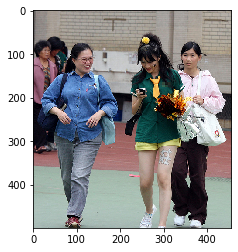

prediction: two girls in skirts walking on the sidewalk
Ground Truth: woman walks as she looks at her cellphone and others look on
Ground Truth: several ladies talking together
Ground Truth: three girls walking one is checking her cellphone
Ground Truth: three girls walk together and talk
Ground Truth: three high school girls walk and talk on astroturf


In [24]:
#OBSERVATION OF PERFORMANCE ON RANDOM IMAGES FROM DEV DATASET
key = list(dev_dataset.keys())[np.random.randint(0, 1000)]
print("model7")
print(key)
feature_vec = encoded_dev_images[key].reshape((1, 1536))
image_path = "../../../Downloads/Flickr8k/Flicker8k_dataset/"+key+".jpg"
image_ = plt.imread(image_path)
plt.imshow(image_)
plt.show()
print("prediction: {}".format(predict7(feature_vec)))
for caption in dev_dataset[key]:
    caption = ' '.join(caption.split()[1:-1])
    print("Ground Truth: {}".format(caption))

In [25]:
#PERFORMANCE ON TRAIN DATASET, DEV DATASET
batch_size = 3
steps = len(train_dataset)//batch_size
train_generator = data_generator(train_dataset, encoded_train_images, word_to_index, max_caption_length, batch_size)
train_performance = model7.evaluate(train_generator, steps=steps, verbose=0)

batch_size = 4
steps = len(dev_dataset)//batch_size
dev_generator = data_generator(dev_dataset, encoded_dev_images, word_to_index, max_caption_length, batch_size)
dev_performance = model7.evaluate(dev_generator, steps=steps, verbose=0)

print("LOSS ON TRAIN DATASET: {}".format(train_performance))
print("LOSS ON DEV DATASET: {}".format(dev_performance))

LOSS ON TRAIN DATASET: [2.672255039215088, 0.4269621670246124]
LOSS ON DEV DATASET: [4.131709098815918, 0.3226974308490753]
